In [19]:
import spacy
import os
import xml.etree.ElementTree as ET
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from spacy import displacy
import scipy.stats
from spacy.tokens import Doc
import pickle

# Tokenize only on whitespace to compare spacy tagger with sparv's tags
class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        return Doc(self.vocab, words=words)

nlp = spacy.load(os.path.join("..", "sv_model_upos", "sv_model0", "sv_model_upos0-0.0.0"))
#nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

## Building Features
To compare sentence structures across countries and decades, we build up a handful of sentence-level metrics. Given a newspaper published in a certain country and decade, we go through every sentence and count the number of words in the sentence, the depth of the sentence's parse tree, and the number of leaves in the parse tree. Each metric aims to capture a different element of the sentence complexity: 

- Sentence length is straightforward. 
- Sentence depth (relative to the length of the sentence for better comparison) shows the complexity of a sentence through the number of clauses in the sentence. 
- Number of leaves (relative to the length of the sentence). A relative number of leaves close to 1 shows a relatively simple tree because of the absence of modifiers or clauses attached to each node. A relative number of leaves close to 0 shows that there are many more nodes that are modified or expanded upon in a dependent clause. 

In [ ]:
# Look at distribution of sentence lengths across languages/times

def traverseSwed(filepath, process, relative=False):
    parser = ET.iterparse(file_path, events=('start','end'))
    parser = iter(parser)
    event, root = next(parser)

    words = ""
    pos = []
    sum_overlaps= 0 
    num_para = 0
    i = 0
    agLength, agDepth, agLeaves = [], [], []
    for event, elem in parser:
        if elem.tag == "w":
            if event == "end":
                #print(elem.attrib['pos'])
                words +=  elem.text + " "
                elem.clear()
            root.clear()
        if elem.tag == "sentence" and event=="end":
            words = words.strip()
            if len(words) == 0: continue
            doc = nlp(words)
            tok = list(doc.sents)[0].root
                
            agLength += [len(doc)]
            agDepth += [treeDepth(tok)/len(doc)]
            agLeaves += [numLeafs(tok)/len(doc)]
            
            words = ""
            i += 1
        if i == 10000: break
    return agLength, agDepth, agLeaves
            
def traverseFin(filepath, process, relative=False):
    agLength, agDepth, agLeaves = [], [], []
    num_sentences = 0
    with open(file_path) as reader:
        words = []
        pos = []
        for line in reader:
            # Start of sentence
            if line[:9] == "<sentence": 
                words = []
                pos_spacy=pos_sparv=pos=[]
            # End of sentence
            if line[:11] == "</sentence>": 
                if(len(words)) == 0: continue
                sent = " ".join(words)
                # print(words)
                doc = nlp(sent)
                tok = list(doc.sents)[0].root
                
                agLength += [len(doc)]
                agDepth += [treeDepth(tok)/len(doc)]
                agLeaves += [numLeafs(tok)/len(doc)]
                
                num_sentences += 1
            # Split up by sentence
            # If at a text line and not just tags
            if line[0] != "<": 
                wordInfo = line.split()
                #print(wordInfo)
                words += [wordInfo[0]]
                pos += [wordInfo[1]]
            if num_sentences == 10000: break
    
    return agLength, agDepth, agLeaves


"""
    For a sentence with the root token tok, returns the depth of the token's subtree. 
"""
def treeDepth(tok):
    if len(list(tok.children)) == 0: return 0 
    
    depths = np.array([treeDepth(c) for c in tok.children]).flatten()
    return max(depths) + 1

"""
    For a sentence with the root token tok, returns the number of leaves in the token's subtree. 
"""
def numLeafs(tok): 
    if len(list(tok.children)) == 0: return 1
    
    leafs = np.array([numLeafs(c) for c in tok.children]).flatten()
    return sum(leafs)

In [23]:
"""
    Given a list of counts for some metric (eg. sentence length), plot the metric
    for the two countries and print the result of a KS test to see see if the two distributions 
    are statistically significant in their difference. 
"""
def showResults(res1, res2, label1, label2, title):
    plt.hist(res1, alpha=0.5, label=label1, density=True)
    plt.hist(res2, alpha=0.5, label=label2, density=True)
    plt.legend()
    plt.title(title)
    plt.show()

    print(f"{label1} stats: {scipy.stats.describe(res1)}")
    print(f"{label2} stats: {scipy.stats.describe(res2)}")
    print("\nIndependence t-test: ", scipy.stats.ks_2samp(res1, res2))

In [14]:
# Sample from the newest Finnish and Swedish publications
# Only run if don't have features saved elsewhere 
if not('swed.pickle' in files) and not('fin.pickle' in files):
    filesSwe = ["kubhist2-carlscronaswekoblad-1870.xml", 
                "kubhist2-lundsweckoblad-1870.xml", 
                "kubhist2-norrkopingstidningar-1870.xml"]

    lengthS, depthS, leafS = [],[],[]
    for name in filesSwe: 
        file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2", name)
        l, d, f, = traverseSwed(file_path, numLeafs, True)
        lengthS += l
        depthS += d
        leafS += f

    filesFin = ["klk-sv-1870.vrt",
               "klk-sv-1874.vrt", 
               "klk-sv-1878.vrt"]
    lengthF, depthF, leafF = [],[],[]
    for name in filesFin: 
        file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", name)
        l, d, f = traverseFin(file_path, numLeafs, True)
        lengthF += l
        depthF += d
        leafF += f

    # Save the feature counts so don't have to re-count later
    import pickle
    swed = {"lenghts": lengthS, 
           "leaves": leafS, 
           "depths": depthS}
    fin = {"lenghts": lengthF, 
           "leaves": leafF, 
           "depths": depthF}
    with open(os.path.join("data", "swed.pickle"), 'wb') as f:
        pickle.dump(swed, f)
    with open(os.path.join("data", "fin.pickle"), 'wb') as f:
        pickle.dump(fin, f)
else:
    print("Features already built, skipping")

Features already built, skipping


In [16]:
# Sample from the oldest Finnish and Swedish publications 

if not('swedOld.pickle' in files) and not('finOld.pickle' in files):
    filesSwe = ["kubhist2-carlscronaswekoblad-1780.xml", 
                "kubhist2-lundsweckoblad-1780.xml", 
                "kubhist2-norrkopingstidningar-1780.xml"]

    lengthS, depthS, leafS = [],[],[]
    for name in filesSwe: 
        file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2", name)
        l, d, f, = traverseSwed(file_path, numLeafs, True)
        lengthS += l
        depthS += d
        leafS += f

    # Using only a subset of the Finnish 1780s data so that balanced with Swedish 1780s data.
    filesFin = ["klk-sv-1782.vrt",
               "klk-sv-1784.vrt",
               "klk-sv-1789.vrt"]
    lengthF, depthF, leafF = [],[],[]
    for name in filesFin: 
        file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", name)
        l, d, f = traverseFin(file_path, numLeafs, True)
        lengthF += l
        depthF += d
        leafF += f

    import pickle
    swed = {"lenghts": lengthS, 
           "leaves": leafS, 
           "depths": depthS}
    fin = {"lenghts": lengthF, 
           "leaves": leafF, 
           "depths": depthF}
    with open(os.path.join("data", "swedOld.pickle"), 'wb') as f:
        pickle.dump(swed, f)
    with open(os.path.join("data", "finOld.pickle"), 'wb') as f:
        pickle.dump(fin, f)
else: 
    print("Features already built, skipping")

Features already built, skipping


In [20]:
# Once the features have been built above, we can re-load them in the future from saved pickle files

# Loading features from the 1870 ("new") publications
lengthFNew, depthFNew, leafFNew = [],[],[]
lengthSNew, depthSNew, leafSNew = [],[],[]
swed, fin = {}, {}
with open(os.path.join("data", "swed.pickle"), 'rb') as f:
    swed = pickle.load(f)
    lengthSNew, depthSNew, leafSNew = swed.values()
with open(os.path.join("data", "fin.pickle"), 'rb') as f:
    fin = pickle.load(f)
    lengthFNew, depthFNew, leafFNew = fin.values()
    
# Loading features from the 1780 ("old") publications
lengthFOld, depthFOld, leafFOld = [],[],[]
lengthSOld, depthSOld, leafSOld = [],[],[]
swed, fin = {}, {}
with open(os.path.join("data", "swedOld.pickle"), 'rb') as f:
    swed = pickle.load(f)
    lengthSOld, depthSOld, leafSOld= swed.values()
with open(os.path.join("data", "finOld.pickle"), 'rb') as f:
    fin = pickle.load(f)
    lengthFOld, depthFOld, leafFOld = fin.values()

In [21]:
print(type(leafSOld), type(leafSNew))

<class 'list'> <class 'list'>


## Comparisons: 
Now that the features have been built, we can compare them across time and langauges. Each combination of country of publication and time period shows that they are statistically different in distribution of each metric, as seen in greater detail below. 

### Finnish vs. Swedish: Sentence Length
Comparing the sentence length of the most recent Finnish vs. Swedish publications (ie. from 1870). We see that sentence length in Finnish publications are on average 9 words longer than Swedish publications, although Finnish sentences tend to vary much more in length than Swedish sentences. Both are heavily skewed right with a long tail of longer sentence lengths. A similar analysis for the 1780s shows a similar result. 

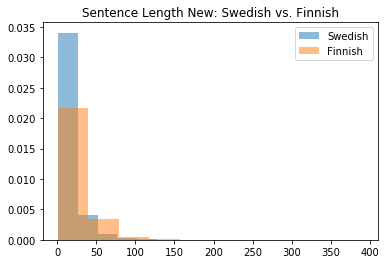

Swedish stats: DescribeResult(nobs=30000, minmax=(1, 254), mean=12.711833333333333, variance=271.67744922052964, skewness=3.320371566624919, kurtosis=18.825124645982026)
Finnish stats: DescribeResult(nobs=30000, minmax=(1, 390), mean=21.915233333333333, variance=435.3806272997989, skewness=2.495281084202087, kurtosis=14.727359923508303)

Independence t-test:  Ks_2sampResult(statistic=0.2997666666666667, pvalue=0.0)


In [27]:
# 1870 Data
showResults(lengthSNew, lengthFNew, "Swedish", "Finnish", "Sentence Length New: Swedish vs. Finnish")

### Finnish vs. Swedish: Relative Tree Depth
Relative tree depth shows the number of dependent clauses in a sentence relative to the number of words in the sentence. A relative tree depth close to 1 shows a tall and "skinny" tree, where each node is dependent on a parent node. (Show an example of what close to 1 means) A relative tree depth close to 0 shows a wider tree (add better explanation). 

Sentences coming from Finnish newspapers tend to have a higher relative tree depth, meaning __. 

Show example of high tree depth
Show example of low tree depth

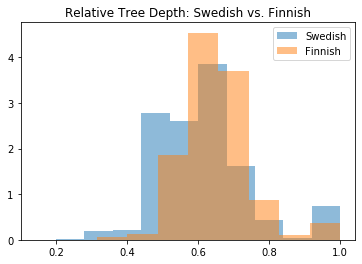

Swedish stats: DescribeResult(nobs=30000, minmax=(0.2, 1.0), mean=0.6282786558321322, variance=0.017879751356547166, skewness=0.9421176752313591, kurtosis=1.5871406309988068)
Finnish stats: DescribeResult(nobs=30000, minmax=(0.14285714285714285, 1.0), mean=0.6446672206705044, variance=0.010550591697062697, skewness=0.9740379539424052, kurtosis=3.2067547151422984)

Independence t-test:  Ks_2sampResult(statistic=0.1486, pvalue=3.970348851865454e-288)


In [29]:
showResults(depthSNew, depthFNew, "Swedish", "Finnish", "Relative Tree Depth: Swedish vs. Finnish")

## Finnish vs. Swedish: Relative Number of Leaves
Sentences coming from Swedish newspapers on average have a greater number of leaves, relative to the sentence length. Show example of low number of leaves
Relative number of leaves shows roughly the logical complement of the relative tree depth. A relatively low number of leaves shows that more nodes are part of a chain of dependencies than have no other nodes dependent on it. 

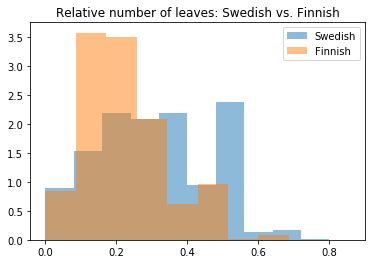

Swedish stats: DescribeResult(nobs=30000, minmax=(0.0, 0.8), mean=0.2964122598058318, variance=0.02382780020697767, skewness=0.08757792725749111, kurtosis=-0.5537783175443818)
Finnish stats: DescribeResult(nobs=30000, minmax=(0.0, 0.8571428571428571), mean=0.22986561594256769, variance=0.016158977098098635, skewness=0.8112612694502062, kurtosis=0.43153467032985926)

Independence t-test:  Ks_2sampResult(statistic=0.24170000000000003, pvalue=0.0)


In [32]:
showResults(leafSNew, leafFNew, "Swedish", "Finnish", "Relative number of leaves: Swedish vs. Finnish")

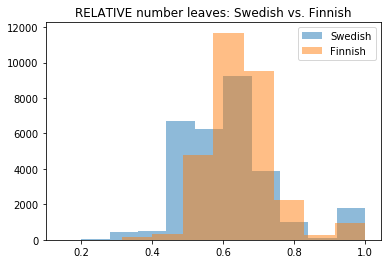

Swedish stats: DescribeResult(nobs=30000, minmax=(0.2, 1.0), mean=0.6282786558321322, variance=0.017879751356547166, skewness=0.9421176752313591, kurtosis=1.5871406309988068)
Finnish stats: DescribeResult(nobs=30000, minmax=(0.14285714285714285, 1.0), mean=0.6446672206705044, variance=0.010550591697062697, skewness=0.9740379539424052, kurtosis=3.2067547151422984)

Independence t-test:  Ttest_indResult(statistic=-16.834898448122363, pvalue=1.937625911965083e-63)


In [32]:
showResults(leafS, leafF, "Swedish", "Finnish", "RELATIVE number leaves: Swedish vs. Finnish")